Data Visualization

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from scipy.integrate import odeint

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

In [2]:
!pip install evojax
from evojax.util import get_params_format_fn

In [3]:
#true params
Ka_true = 2.821 # 1/h - not in spreadsheet
Ke_true = 0.693/6.3 # 1/h
V_blood_true = 19 # L
V_gut_true = 1.3612 # L
dosage_true = 100.5348 #mg, just for reference

In [4]:
#initial conditions
A1_init = 73.864090508375 # / V_gut_true # (mg/L) #needs to be decided
A2_init = 0 # (mg/L)

In [5]:
# task array
# Ka_params = jnp.linspace(1., 10., 5)
# Ke_params = jnp.linspace(0.0001, 1., 5)
# V_gut_params = jnp.linspace(0.5, 2.5, 5) #cannot divide by 0, trying to only predict blood for now #V1
# V_blood_params = jnp.linspace(10., 25., 5) #cannot divide by 0, trying to only predict blood for now #V2

# task_params = jnp.stack((Ka_params, Ke_params, V_gut_params, V_blood_params), axis=1)

task_params = np.array([[Ka_true, Ke_true, V_gut_true, V_blood_true]])

n_task = len(task_params)
n_task, task_params

(1, array([[ 2.821 ,  0.11  ,  1.3612, 19.    ]]))

Obtaining Ground Truth

In [6]:
#caffeine equation solution generator
def caffeine(y, t, Ka, Ke, V_gut, V_blood):
    """A1 and A2 terms are not divided by V, they are just divided before being plotted"""
    A1_sys, A2_sys = y
    dydt = [-Ka* (A1_sys), Ka*(A1_sys) - Ke*(A2_sys)]
    return dydt

In [7]:
data_A1, data_A2, data_S = [], [], [] #collect all 6 tasks (different combination of a1 a2) #data S is all zeroes
t = jnp.linspace(0, 24, 201)
t_param = t #copy for calculating ODE
t = np.expand_dims(t, axis=1) #for data_X

data_T = t
for task in task_params:

    y0 = [A1_init * V_gut_true, A2_init * V_blood_true] #must scale A1 and A2 if all resulting A1/A2 values are divided by V

    #get ODE soln for A2
    sol = odeint(caffeine, y0, t_param, args=(Ka_true, Ke_true, V_gut_true, V_blood_true))
    A1_soln = sol[:, 0:1]
    A2_soln = sol[:, 1:2]

    #divide all values by V
    data_A2.append(A2_soln/V_blood_true)
    data_A1.append(A1_soln/V_gut_true)

    #init an array of zeroes for g
    s_array = np.zeros(len(A2_soln))
    s_array = np.expand_dims(s_array, axis=1)
    data_S.append(s_array)

data_A1, data_A2, data_S = jnp.array(data_A1[0]), jnp.array(data_A2[0]), jnp.array(data_S[0])
data_y = data_A1 * Ka_true
print (data_T.shape, data_A1.shape, data_A2.shape, data_S.shape, data_y.shape)

(201, 1) (201, 1) (201, 1) (201, 1) (201, 1)


Text(0, 0.5, 'A2')

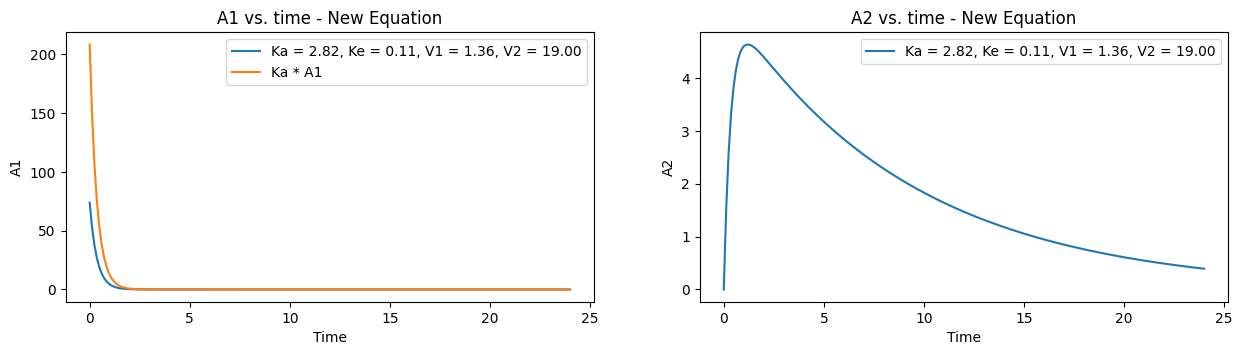

In [8]:
fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1,2,1)


params = task_params[0]
plt.plot(data_T, data_A1, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))
plt.plot(data_T, data_y, label='Ka * A1')
# plt.plot(data_T, data_A1_csv[0], label='CSV data')

plt.title("A1 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A1");
ax1 = fig.add_subplot(1,2,2)


params = task_params[0]
plt.plot(data_T, data_A2, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))

    # plt.plot(data_T, data_A2_csv[0], label='CSV data')
plt.title("A2 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A2")

## PySR

**Mounting colab notebook to Drive**

In [9]:
# Mounting colab notebook to drive
from google.colab import drive
drive.mount('/content/drive')
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Julia installation (run once)**

In [10]:
# Julia installation
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

*Installing PySR and relevant packages*

In [11]:
# Installing PySR (and relevant packages)
!pip install pysr

*Importing relevant modules*

In [12]:
#Importing relevant modules
import os
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pysr import pysr, best, PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


*Verifying working directory*

In [13]:
input_path = '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Caffeine/Text Files/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Caffeine/Text Files


*Perfect data - generation, plotting, symbolic regression*

In [14]:
#Generating data sets compatible with PySR wagwarn bot dat dign
x_values = jnp.hstack([data_A1, data_A2])
y_values = data_y[:, 0]
print(y_values.shape)

np.save('x_values_pysr_A1A2.npy',x_values)
np.savetxt('x_values_pysr_A1A2.txt',x_values,delimiter=' ')

np.save('y_values_pysr_KaA1.npy',y_values)
np.savetxt('y_values_pysr_KaA1.txt',y_values,delimiter=' ')

# Converting data into a .txt format compatible with matplotlib (for plotting step)
with open('xy_data_pysr_y=KaA1.txt', 'w') as f:
  for r in range(201):
    f.write(f'{x_values[:, 0][r]} {x_values[:, 1][r]} {y_values[r]}\n')

(201,)


                0         1             2
0    7.386409e+01  0.000000  2.083706e+02
1    5.265214e+01  1.509122  1.485317e+02
2    3.753173e+01  2.565072  1.058770e+02
3    2.675354e+01  3.298249  7.547174e+01
4    1.907058e+01  3.801602  5.379810e+01
..            ...       ...           ...
196  1.772178e-11  0.414256  4.999314e-11
197  8.033132e-12  0.408824  2.266147e-11
198  7.997448e-12  0.403463  2.256080e-11
199  7.916035e-12  0.398172  2.233113e-11
200  6.091490e-12  0.392950  1.718409e-11

[201 rows x 3 columns] (201, 3)


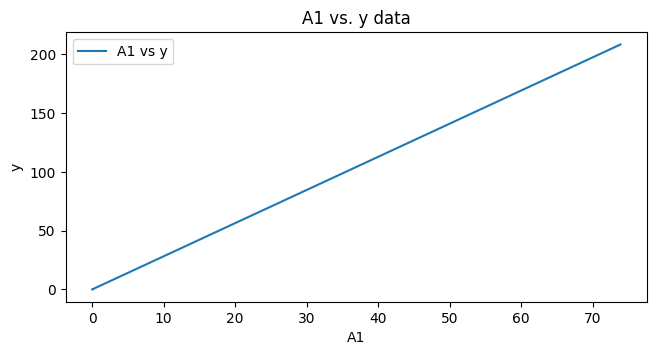

In [15]:
# Printing perfect data with Pandas and plotting it with matplotlib
df=pd.read_csv(input_path + 'xy_data_pysr_y=KaA1.txt',sep=" ",header=None)

fig = plt.figure(figsize=(7.5, 3.5))

plt.plot(df[0], df[2], label='A1 vs y')

plt.title("A1 vs. y data"); plt.legend();
plt.xlabel("A1"); plt.ylabel("y");
print(df, df.shape)

In [16]:
for num_iters in [10]: #, 30, 60, 80, 100 #for loop for hyperparameter tuning
    model = PySRRegressor(
        niterations=num_iters,  # < Increase me for better results
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "sign",
            "neg",
            "cos",
            "exp",
            "sin",  # Pre-defined library of operators (see docs)
            "inv(x) = 1/x",  # Define your own operator! (Julia syntax)
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},
        # ^ Define operator for SymPy as well
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        # ^ Custom loss function (julia syntax)
    )

    print(model.fit(x_values, y_values))
    #for saving the model
    # model_path = input_path + 'data/model-%2d.pkl'%(num_iters)

    # with open(model_path, 'wb') as file:
    #   pickle.dump(model, file)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.070e+04
Head worker occupation: 42.4%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 70 / 150 total iterations (46.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.830e+02  1.594e+01  y = x₀
3           3.795e-02  4.240e+00  y = x₀ / 0.35122
4           3.405e-02  1.084e-01  y = x₀ / cos(-1.2051)
5           9.471e-13  1.594e+01  y = (x₀ * 2.7316) * 1.0327
6           7.296e-13  2.609e-01  y = (x₀ * neg(-2.821)) - 2.9149e-08
11          3.926e-13  1.240e-01  y = (((x₀ * 3.0279) + -0.17945) + (x₀ / -4.8331)) + 0.17945
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.
PySRRegressor.equations_ = [
	   pick      score                            

In [17]:
print(model.sympy()) #get best fit expression

x0/(-4.8330603) + x0*3.0279083 - 0.17944655 + 0.17944644


Plotting solution

In [38]:
def y_soln(x0, x1):
  return x0/(-4.8330603) + x0*3.0279083 - 0.17944655 + 0.17944644

In [39]:
soln = y_soln(data_A1, data_A2)
soln.shape

(201, 1)

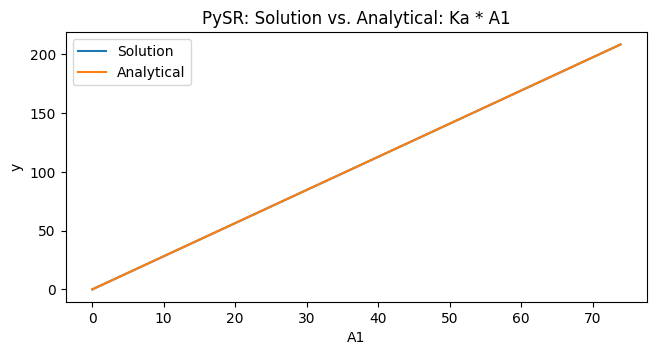

In [40]:
fig = plt.figure(figsize=(7.5, 3.5))

params = task_params[0]
plt.plot(data_A1, soln, label='Solution')
plt.plot(data_A1, data_y, label='Analytical')
# plt.plot(data_T, data_A1_csv[0], label='CSV data')

plt.title("PySR: Solution vs. Analytical: Ka * A1"); plt.legend();
plt.xlabel("A1"); plt.ylabel("y");

In [42]:
#MSE between SR solution and analytical solution
print(soln.shape, data_y.shape)
jnp.mean(jnp.square(soln - data_y))

(201, 1) (201, 1)


Array(1.945091e-13, dtype=float64)